# Heavytail supported in submanifold example
## How to generate data

$y$ is a $c$ dimensional random vector with each element $y_i \sim StandardCauchy$. <br>
$t$ is a $c$ dimensional random vector with each element $t_i \sim Unif([0.5, 2])$. <br>
For each element $i$, define $z_i = sign(y_i) |y_i|^{t_i}$. <br>
Then embed the vector $z$ into $d>c$ dimensional space with $z_j =0$ for $j > c$.

---
For the experiment, we draw $t$ only once and fix the values.
We tested for the case with $c=10$, $d=100$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

vis_dir = "./assets/Heavytail_submanifold/visualizations/"
if not os.path.exists(vis_dir):
    os.makedirs(vis_dir)

submanifold dimension: 10
Power of each axis: [[1.31510741 0.91755408 1.13677639 1.7671642  0.50707828 0.68235368
  1.50612363 1.73877913 0.70505988 1.36263999]]


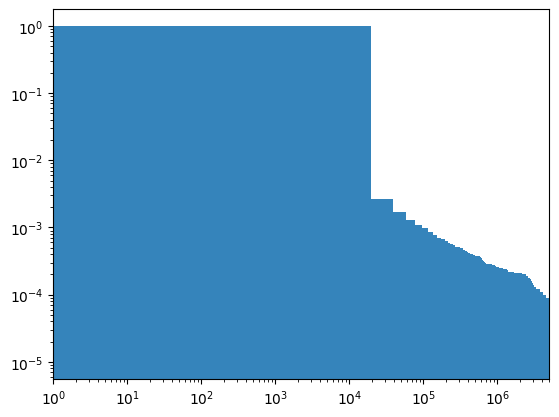

In [2]:
def embed_data(x, di, df, offset):
    z=np.concatenate((offset*np.ones([x.shape[0],di]),x),axis=1)
    z=np.concatenate((z,offset*np.ones([x.shape[0],df])),axis=1)

    return z
            
c = 10
d = 100
y = np.random.standard_cauchy(size=(100000, c))

np.random.seed(100)
t = np.random.uniform(low=0.5, high=2.0, size=(1, c))

z = embed_data(np.sign(y)* (abs(y) ** t), di = 0, df=d, offset=0.0)

print(f"submanifold dimension: {c}")
print(f"Power of each axis: {t}")

plt.yscale('log')
plt.xscale('log')
plt.hist(np.abs(z[:,3]), alpha=0.9,cumulative=-1, density=True, bins=20000)
plt.xlim([1,5000000])
    
plt.show()

---

## Plot result
For each submanifold dimension, we compare true samples and generated samples by CCDF. Call a function ```draw_plot1D```.

In [3]:
from scipy.interpolate import splev, splrep
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def draw_plots1D(generated, true, label, c=c):
        
    binsize = 20000   
    fig_scale = 3
    
    xlim = 5000000
    xlim_min = 1.0
    bins = np.linspace(xlim_min, xlim, binsize)
    
    areas=[]
    
    # Scatter plot
    f, axs = plt.subplots(2, 5, figsize=(5*fig_scale+2 ,2*fig_scale +1))
    for i in range(c):
        r,c = np.divmod(i,5)
        axs[r,c].set_xscale('log')
        axs[r,c].set_yscale('log')
    
        h = plt.hist(true[:,i], alpha=0.9,cumulative=-1, density=True, bins=bins, color='white')
        flag = False
        for j in range(binsize-1):
            if not np.isnan(h[0][j]):
                flag = True
            elif np.isnan(h[0][j]) and flag==False:
                h[0][j] = 1.0
            else:
                h[0][j] = 0.0
    
        spl = splrep(h[1][1:], h[0], s=0.01, per=False)
        x2 = np.linspace(h[1][1], h[1][-1], 200)
        y2 = splev(x2, spl)
        axs[r,c].loglog(x2, y2, 'r-', linewidth=2.0, alpha=0.6, label='true')
        
        h_gen = axs[r,c].hist(generated[:,i], label="generated", alpha=1.0 , cumulative=-1, density=True, bins=bins, color = 'slategray')
        if i == c-1:
            plt.legend(fontsize=11, loc='lower left')   
        
        flag = False
        for j in range(binsize-1):
            if not np.isnan(h_gen[0][j]) and flag==False:
                flag = True
                if j != 0:
                    axs[r,c].axvspan(xlim_min, h_gen[1][j-1], alpha=1.0, color = 'slategray')
            elif np.isnan(h_gen[0][j]) and flag==False:
                h_gen[0][j] = 1.0
            elif np.isnan(h_gen[0][j]) and flag==True:
                h_gen[0][j] = 0.0
        if np.mean(h_gen[0]) == 1.0:
            axs[r,c].axvspan(xlim_min, h_gen[1][-1], alpha=1.0, color = 'slategray')

        
        axs[r,c].set_xlim([xlim_min, xlim])
        axs[r,c].set_ylim([1e-3, 1.0])
        axs[r,c].set_xlabel('x')
        axs[r,c].set_ylabel('CCDF')
        
        areas.append(np.sum(np.abs(h[0]-h_gen[0]) * (h[1][1:]-h[1][:-1])))
        print("Area: ", areas[-1])
        
    plt.tight_layout()   
    plt.savefig(f"{vis_dir}Heavytail_submnfld_{label.replace(' ', '_')}.png")
    plt.show()
    
    return areas


In [5]:
from scipy.stats import gaussian_kde

In [6]:
def plot_orthogonal_saturation(y, label):
    y = np.reshape(y, (-1))
    
    x= np.linspace(y.min(), y.max(), 1000)
    z = gaussian_kde(y)(x)
    plt.plot(x, z, linestyle='-')
    plt.xlabel('x')
    plt.ylabel('density')
    plt.tight_layout()
    plt.savefig(f"{vis_dir}Heavytail_submnfld_{label.replace(' ', '_')}.png")
    plt.show()
    
def dist_orth(y):
    return np.mean(np.linalg.norm(y, axis=1) )

alpha=02.00-Lip=1 GPA
Area:  95.90713248657225
Area:  2.949886180460424
Area:  37.57010271535011
Area:  1509.1951917099511
Area:  0.009992504021683899
Area:  0.1463872317538068
Area:  382.58087885726826
Area:  1200.5382581573717
Area:  0.5209705417218846
Area:  247.25913079016624


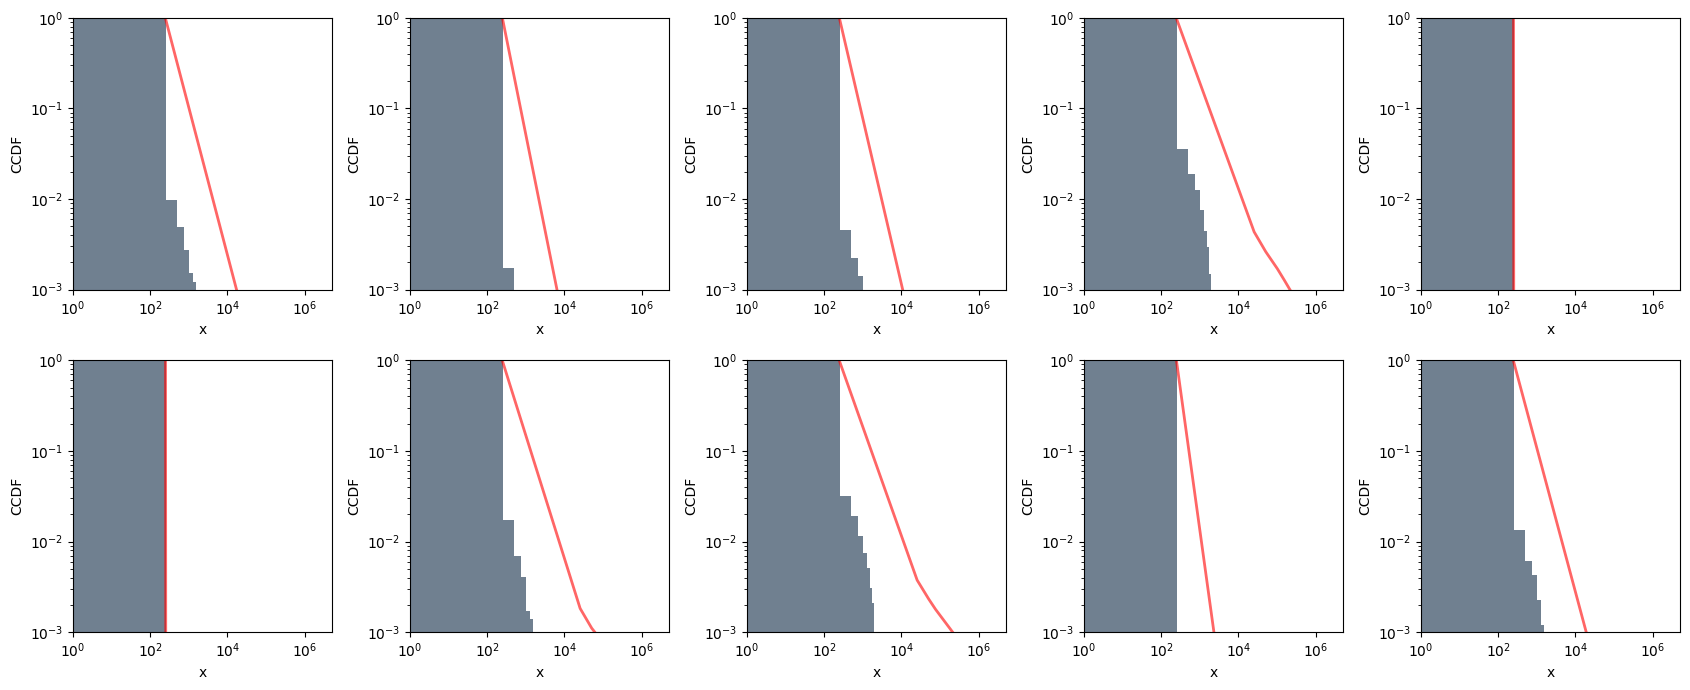

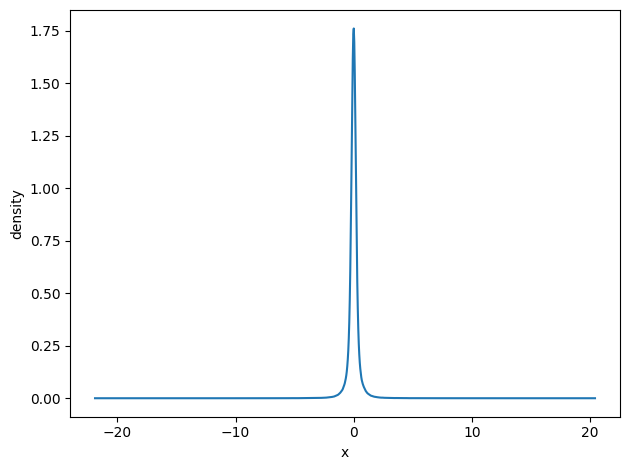

L1 error: 347.6677931174637
Distance to orthogonal space:  3.4179087


In [7]:
# GPA (Light to Heavy)

fs = ['alpha=02.00',]# 'reverse_KL', ]
#beta1 = 'infty'
#beta2 = df + d

W2s = []
for f in fs:
    if f in ['KL', 'reverse_KL']:
        alias_f = f + '=02.00'
    else:
        alias_f = f
    filename = "assets/Heavytail_submanifold/%s-Lipschitz_1.0000_10000_10000_00_4.pickle" % (alias_f)
    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    print(f"{f}-Lip=1 GPA")
    
    areas = draw_plots1D(np.abs(result['trajectories'][-1]), np.abs(z), f"submanifold {f}-Lip=1 GPA")
    plot_orthogonal_saturation(result['trajectories'][-1][:,c:], f"orthogonal {f}-Lip=1 GPA")
    
    print("L1 error:", np.mean(areas))
    print("Distance to orthogonal space: ", dist_orth(result['trajectories'][-1][:,c:]) )

alpha=02.00 GPA


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Area:  4999647.731348338
Area:  4999745.471038047
Area:  4999708.732537212
Area:  4998218.7954613995
Area:  4999748.977556873
Area:  4999748.797029322
Area:  4999358.110397542
Area:  4998528.231242561
Area:  4999748.423525203
Area:  4999494.57562608


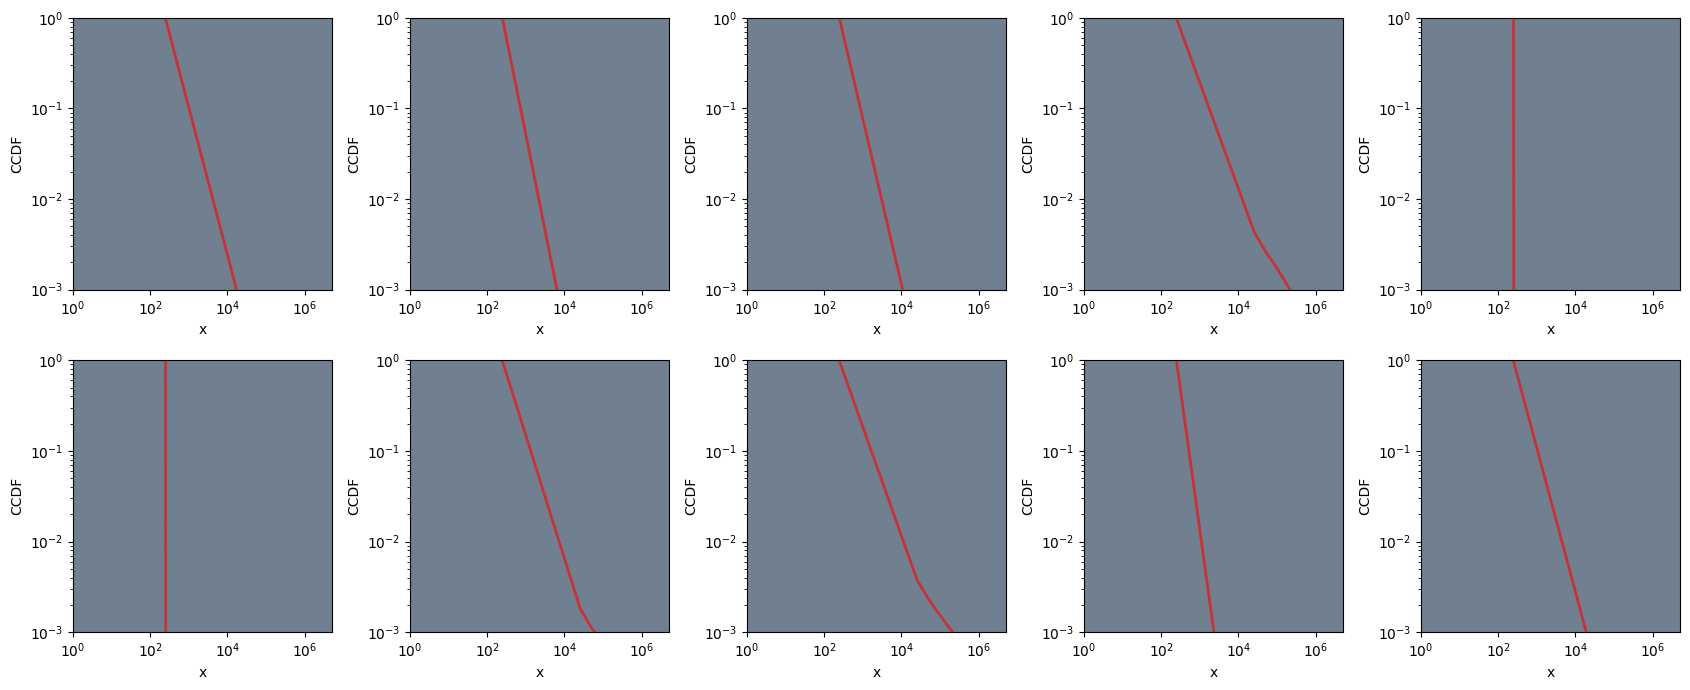

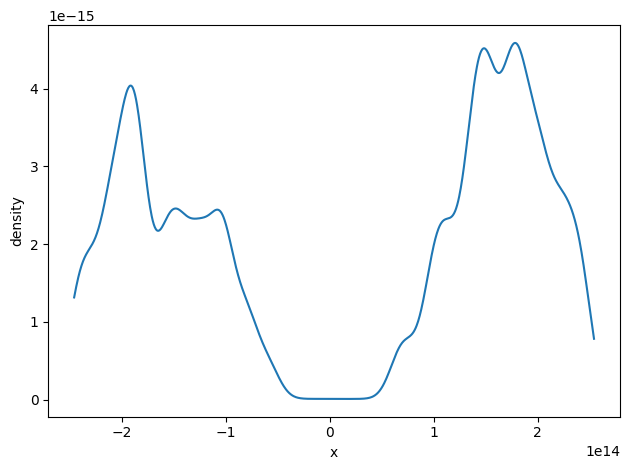

L1 error: 4999394.784576259
Distance to orthogonal space:  1715009700000000.0


In [8]:
# GPA (Light to Heavy)

fs = ['alpha=02.00',]# 'reverse_KL', ]
#beta1 = 'infty'
#beta2 = df + d
W2s = []

for f in fs:
    if f in ['KL', 'reverse_KL']:
        alias_f = f + '=02.00'
    else:
        alias_f = f
    filename = "assets/Heavytail_submanifold/%s-Lipschitz_inf_10000_10000_00_4.pickle" % (alias_f)
    
    with open(filename, "rb") as fr:
        param, result = pickle.load(fr)
        
    print(f"{f} GPA")
    areas = draw_plots1D(np.abs(result['trajectories'][-1]), np.abs(z), f"submanifold {f} GPA")
    
    plot_orthogonal_saturation(result['trajectories'][-1][:,c:], f"orthogonal {f} GPA")
    print("L1 error:", np.mean(areas))
    print("Distance to orthogonal space: ", dist_orth(result['trajectories'][-1][:,c:]) )

alpha=02.00-Lip=1 GAN
Area:  100.73096479909084
Area:  3.51651133005821
Area:  40.25501216612903
Area:  1516.827889031927
Area:  0.009992504021711656
Area:  0.1905200562238035
Area:  386.1287292772687
Area:  1211.342528028275
Area:  0.5640241753747532
Area:  253.69570183102365


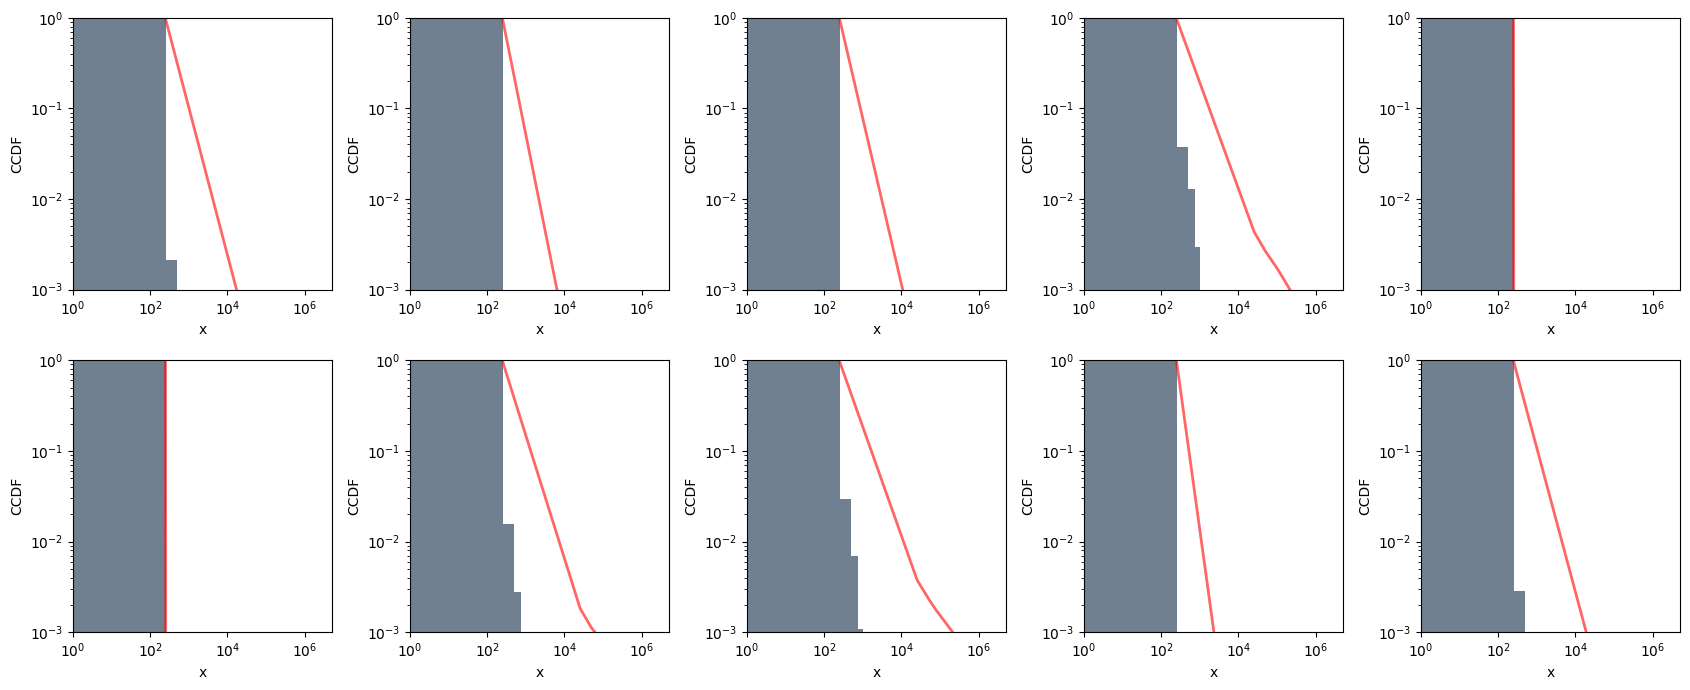

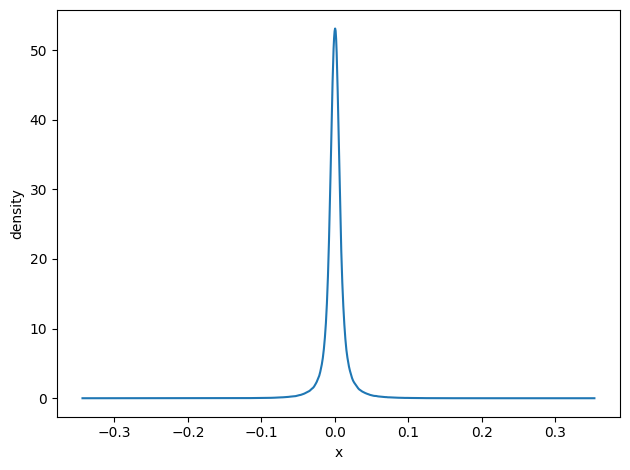

L1 error: 351.32618731993927
Distance to orthogonal space:  0.10990143


In [9]:
# GAN (Light to Heavy)

fs = ['alpha=02.00',]# 'reverse_KL', ]
#beta1 = 'infty'
#beta2 = df + d
W2s = []

for f in fs:
    if f in ['KL', 'reverse_KL']:
        alias_f = f + '=02.00'
    else:
        alias_f = f
    filename = "assets/Heavytail_submanifold/%s-Lipschitz_1.0000_GAN_10000samples_0.pickle" % f

    
    with open(filename, "rb") as fr:
        [generated] = pickle.load(fr)
        
    print(f"{f}-Lip=1 GAN")
    areas = draw_plots1D(np.abs(generated), np.abs(z), f"submanifold {f}-Lip=1 GAN")
    plot_orthogonal_saturation(generated[:,c:], f"orthogonal {f}-Lip=1 GAN")
    print("L1 error:", np.mean(areas))
    print("Distance to orthogonal space: ", dist_orth(generated[:,c:]) )

alpha=02.00 GAN
Area:  4999647.731348338
Area:  4999745.471038047
Area:  4999708.732537212
Area:  4998218.7954613995
Area:  4999748.977556873
Area:  0.1905200562238035
Area:  4999358.110397542
Area:  4998528.231242561
Area:  4999748.423525203
Area:  4999494.57562608


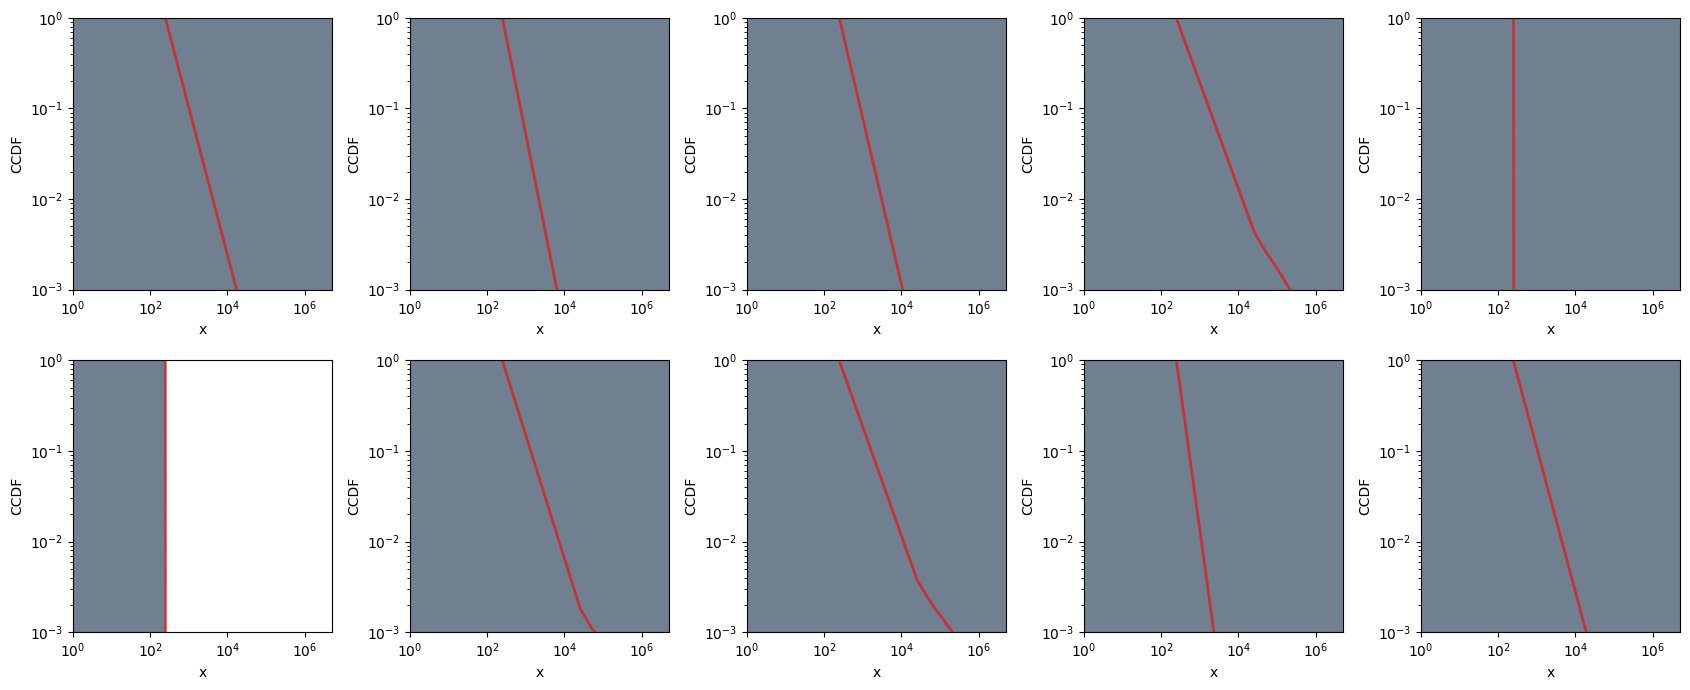

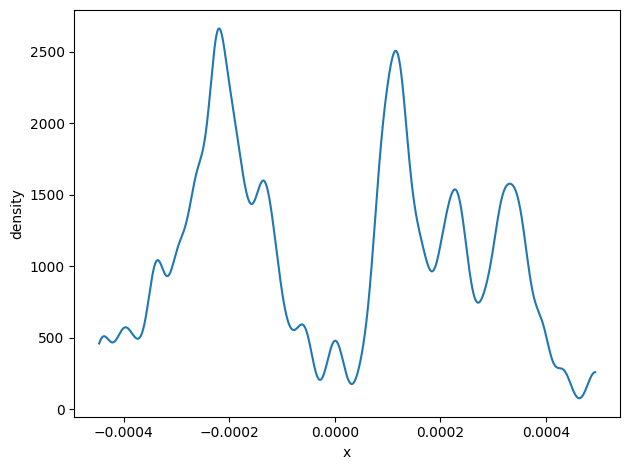

L1 error: 4499419.923925332
Distance to orthogonal space:  0.0024480582


In [10]:
# GAN (Light to Heavy)

fs = ['alpha=02.00',]# 'reverse_KL', ]
#beta1 = 'infty'
#beta2 = df + d
W2s = []

for f in fs:
    if f in ['KL', 'reverse_KL']:
        alias_f = f + '=02.00'
    else:
        alias_f = f
    filename = "assets/Heavytail_submanifold/%s-Lipschitz_inf_GAN_10000samples_0.pickle" % f

    
    with open(filename, "rb") as fr:
        [generated] = pickle.load(fr)
        
    print(f"{f} GAN")
    areas = draw_plots1D(np.abs(generated), np.abs(z), f"submanifold {f} GAN")
    plot_orthogonal_saturation(generated[:,c:], f"orthogonal {f} GAN")
    print("L1 error:", np.mean(areas))
    print("Distance to orthogonal space: ", dist_orth(generated[:,c:]) )

Area:  4999647.731348338
Area:  4999745.471038047
Area:  4999708.732537212
Area:  4998218.7954613995
Area:  4999748.977556873
Area:  4999748.797029322
Area:  4999358.110397542
Area:  4998528.231242561
Area:  4999748.423525203
Area:  4999494.57562608


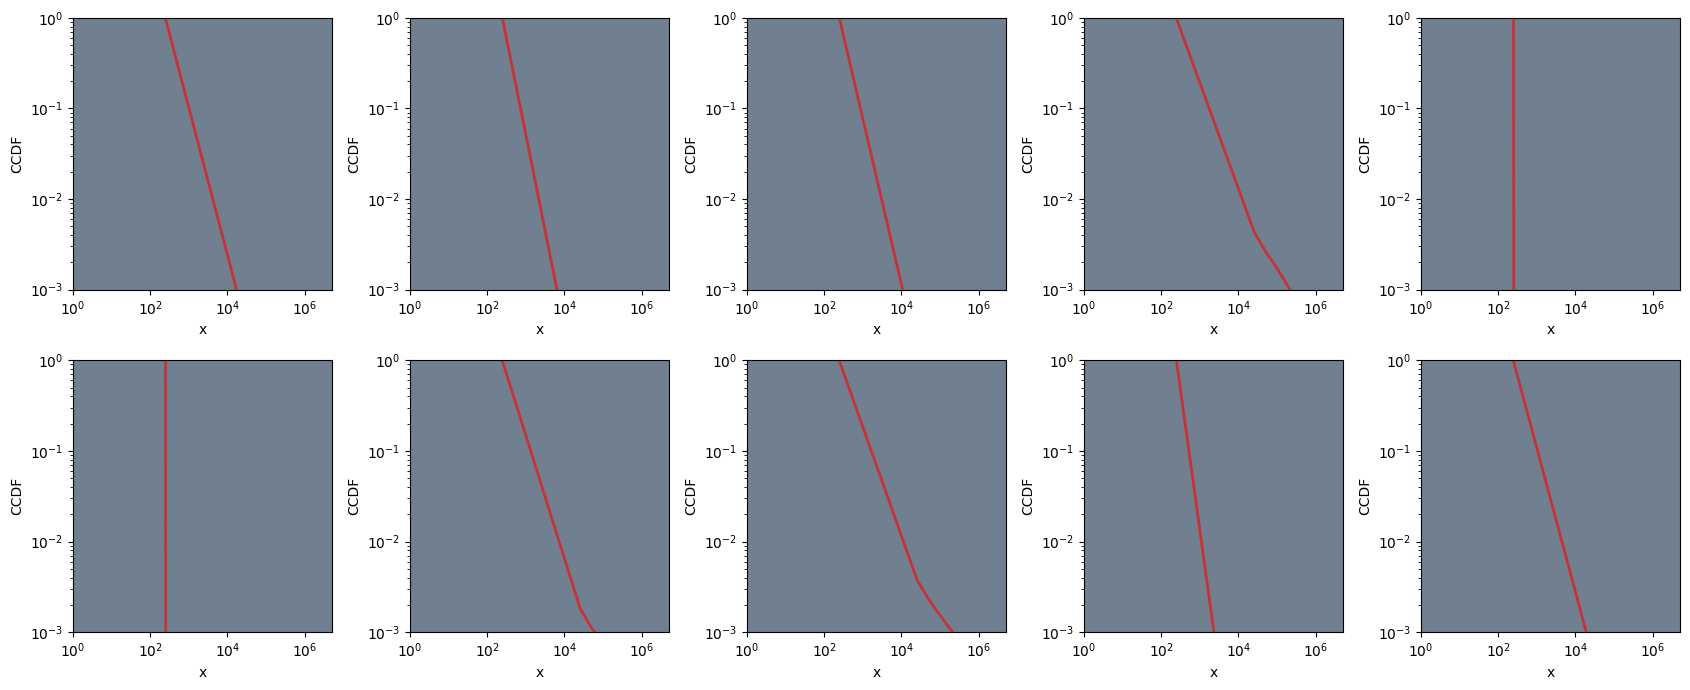

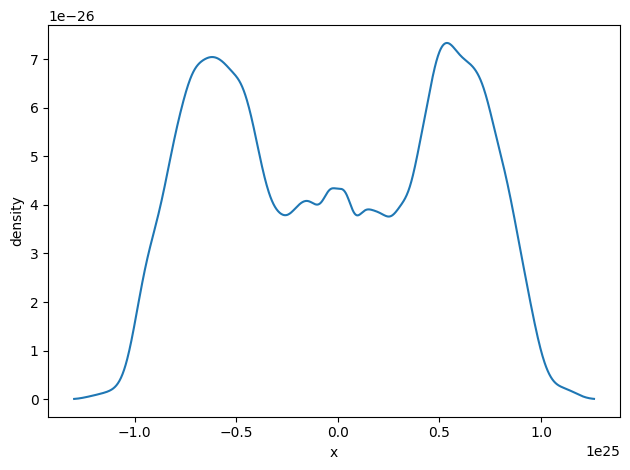

L1 error: 4999394.784576259
Distance to orthogonal space:  inf


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/linalg/linalg.py:2556: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


In [11]:
# OT flow
filename = "assets/Heavytail_submanifold/otflow_200samples.pickle"
W2s = []
with open(filename, "rb") as fr:
    [normalized, generated] = pickle.load(fr)

areas = draw_plots1D(np.abs(generated), np.abs(z), "submanifold OT flow T=50")
plot_orthogonal_saturation(generated[:,c:], f"orthogonal OT flow T=50")
print("L1 error:", np.mean(areas))
print("Distance to orthogonal space: ", dist_orth(generated[:,c:]) )

Area:  4999647.731348338
Area:  4999745.471038047
Area:  4999708.732537212
Area:  4998218.7954613995
Area:  4999748.977556873
Area:  4999748.797029322
Area:  4999358.110397542
Area:  4998528.231242561
Area:  4999748.423525203
Area:  4999494.57562608


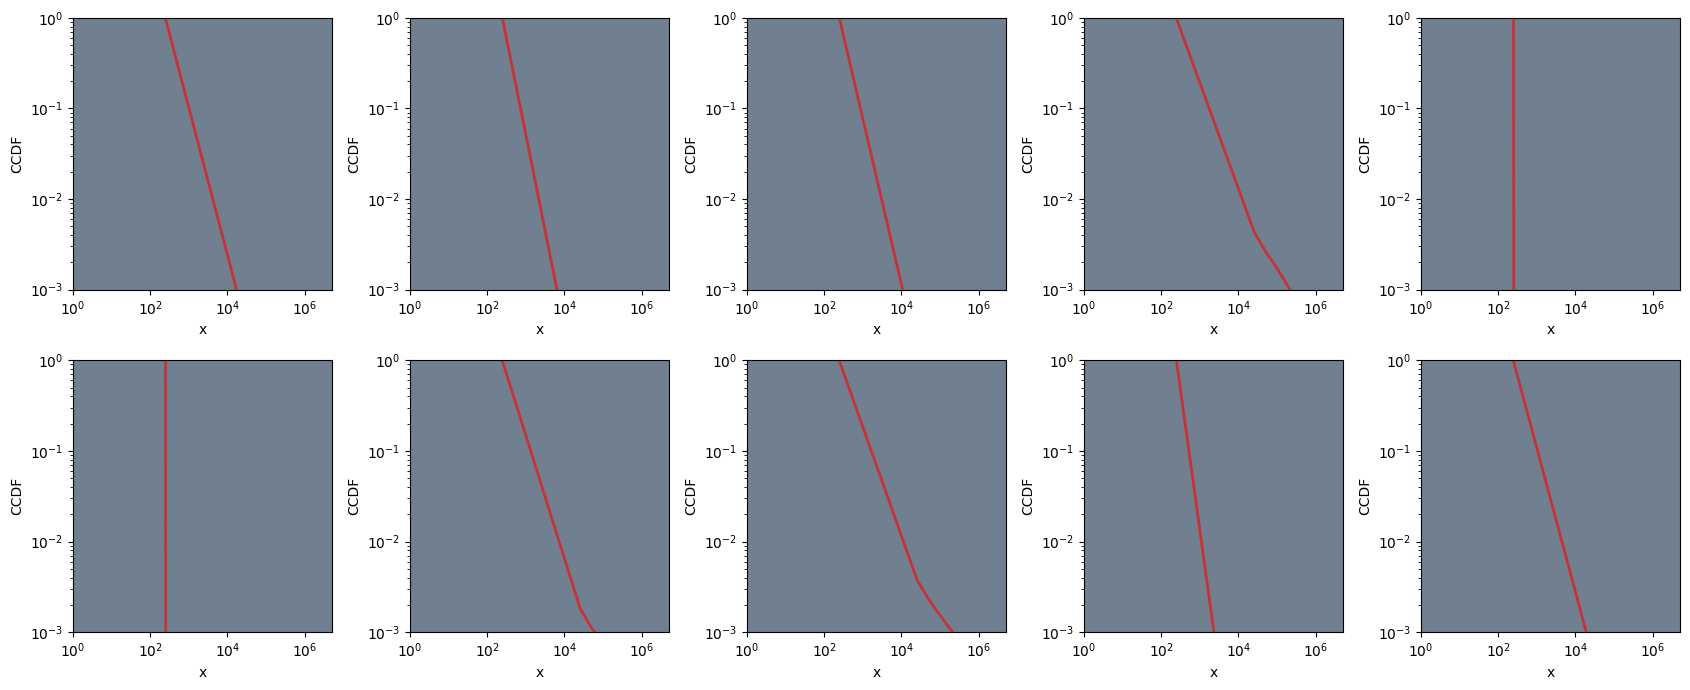

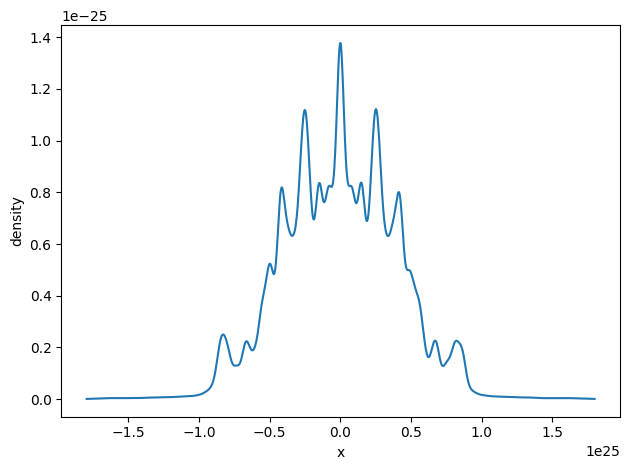

L1 error: 4999394.784576259
Distance to orthogonal space:  inf


In [12]:
# Normalizing flow
filename = "assets/Heavytail_submanifold/no_otflow_200samples.pickle"
W2s = []
with open(filename, "rb") as fr:
    [normalized, generated] = pickle.load(fr)

areas = draw_plots1D(np.abs(generated), np.abs(z), "submanifold CNF T=50")
plot_orthogonal_saturation(generated[:,c:], f"orthogonal CNF T=50")
print("L1 error:", np.mean(areas))
print("Distance to orthogonal space: ", dist_orth(generated[:,c:]) )

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesI

Area:  112.61160577672413
Area:  23.383872795922564
Area:  55.66450549545821
Area:  1521.442556941325
Area:  21.09479128431758
Area:  20.003249953490837
Area:  395.3038333075881
Area:  1215.7143116071475
Area:  21.67151280866187
Area:  264.4560048980387


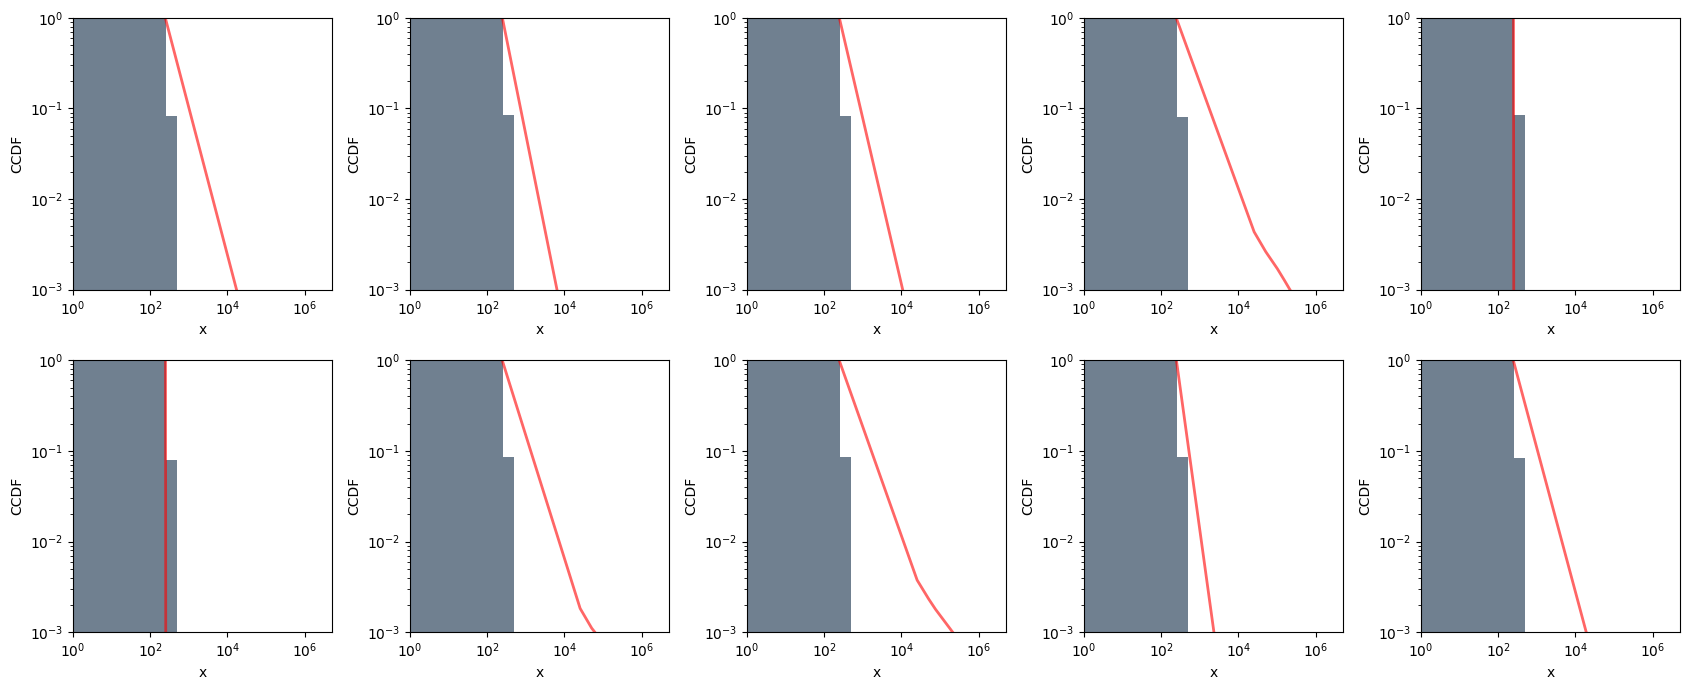

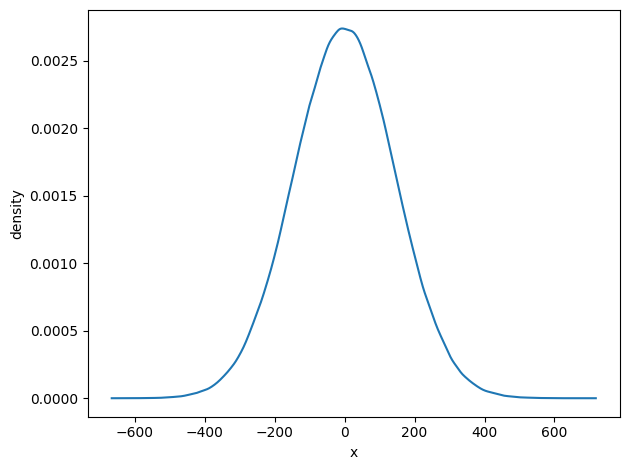

L1 error: 365.13462448686744
Distance to orthogonal space:  1444.178


In [13]:
# VE SGM
filename = "assets/Heavytail_submanifold/ve_sgm_heavytail_submanifold_10000samples.pickle"
W2s = []
with open(filename, "rb") as fr:
    ou_normal, ou_reverse = pickle.load(fr)
    
areas = draw_plots1D(np.abs(ou_reverse), np.abs(z), f"submanifold VE SGM")
plot_orthogonal_saturation(ou_reverse[:,c:], f"orthogonal VE SGM")
print("L1 error:", np.mean(areas))
print("Distance to orthogonal space: ", dist_orth(ou_reverse[:,c:]) )